In [2]:
import pandas as pd                # Προσθήκη DataFrames για αξιόπιστη αποθήκευση/μετασχηματισμό.
import numpy as np                 # Προσθήκη Seaborn για αριθμητικές πράξεις υψηλής απόδοσης & δημιουργία μασκών/πινάκων.
import matplotlib.pyplot as plt    # Προσθήκη Matplotlib για  οπτικοποίηση περιγραφικών αποτελεσμάτων.
from sklearn.preprocessing import StandardScaler     # Τυποποίηση χαρακτηριστικών (μηδενικό μέσο/μονάδα διασποράς).
from sklearn.cluster import KMeans, MiniBatchKMeans  # Εισαγωγή αλγόριθμων K-Means (κλασικός και mini-batch).


# ==== 1) Φόρτωση δεδομένων ====
PATH = "Dataset_Cleaned.xlsx"    # Διαδρομή εισόδου η οποία παραμένει παραμετροποιήσιμη.
df = pd.read_excel(PATH)    # Ανάγνωση προεπεξεργασμένου dataset σε DataFrame (αναπαραγωγιμότητα/σταθερότητα τύπων).


# ==== 2) Ρυθμίσεις βασικών πεδίων ====
RISK_COL = "Thyroid_Cancer_Risk"    # Μεταβλητή κλινικού κινδύνου για εκ των υστέρων σύγκριση (την οποία δεν "βλέπει" ο αλγοριθμοσ).
TARGET_COLS_TO_EXCLUDE = {RISK_COL, "Diagnosis"}  #Αποκλεισμός στηλών-στόχων από το clustering για να διατηρηθεί η μη-επιβλεπόμενη φύση. 


# ==== 3) Επιλογή αριθμητικών χαρακτηριστικών ====
feature_cols = [c for c in df.columns if c not in TARGET_COLS_TO_EXCLUDE]  # Διατήρηση υποψήφιων γνωρισμάτων εκτός στηλών-στόχων.
X = df[feature_cols].select_dtypes(include=[np.number]).copy()    #Φιλτράρισμα για διατήρηση μόνο αριθμητικών στηλών (απαίτηση K-Means).

# Δειγματοληψία για αποδοτικότητα & ταχύτητα σε πολύ μεγάλα σύνολα.
MAX_N = 10000             # Ορισμός μέγιστου μεγέθους δείγματος για λόγους αποδοτικότητας.
if len(X) > MAX_N:         #Έλεγχος  αν το dataset υπερβαίνει το όριο.
    #Τυχαία δειγματοληψία με σταθερό seed για αναπαραγωγιμότητα, το index επανακαθορίζεται για συνέπεια.
    df = df.sample(n=MAX_N, random_state=42).reset_index(drop=True)    
    X = df[feature_cols].select_dtypes(include=[np.number]).copy()    # Επαναπροσδιορισμός X στο ίδιο υποσύνολο.


# ==== 4) Κανονικοποίηση (σημαντικότερο part για K-Means) ====
scaler = StandardScaler()            #Ορισμός τυποποιητή (μηδενικό μέσο, μονάδα τυπικής απόκλισης).
X_scaled = scaler.fit_transform(X)   #Προσαρμογή/μετασχηματισμός: αποτρέπει κυριαρχία χαρακτηριστικών μεγάλης κλίμακας.


# ==== 5) Εφαρμογή K-Means με τρεις συστάδες (k=3) ====

k = 3  # Προκαθορισμένος αριθμός συστάδων (ευθυγραμμισμένος με υποθετική τριμερή δομή).
    # Επιλογή του random_state και αυξηση της n_init για απλότητα και σταθερότητα
try:  
    #Ο random_state εξασφαλίζει αναπαραγωγιμότητα ενώ η αύξηση του n_init μειώνει τον κίνδυνο τοπικών ελαχίστων.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)  
    cluster_labels = kmeans.fit_predict(X_scaled)     # Εκπαίδευση και απόδοση ετικετών συστάδας για κάθε παρατήρηση.
    centers_scaled = kmeans.cluster_centers_          # Συντεταγμένες κεντροειδών στον τυποποιημένο χώρο.
except Exception:
    # Εναλλακτική χρήση του MiniBatchKMeans για μεγαλύτερη αποδοτικότητα σε πολύ μεγάλα σύνολα δεδομένων.
    # Σε περίπτωση που  ο KMeans καθιστά αργός στον υπολογιστή. 
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, n_init=10, max_iter=100)
    cluster_labels = kmeans.fit_predict(X_scaled)    # Εκπαίδευση και ταξινόμηση με προσεγγιστική βελτιστοποίηση.
    centers_scaled = kmeans.cluster_centers_         # Εκτιμώμενα κεντροειδή με βάση mini-batches.

# Ενσωμάτωση των ετικετών συστάδας στο αρχικό DataFrame για μετέπειτα ανάλυση.
df["Cluster"] = cluster_labels



# ==== 6) Σύγκριση clusters με κλινικό δείκτη κινδύνου /Risk (contingency table) ====

contingency = pd.crosstab(df["Cluster"], df[RISK_COL].astype(str))
print("\n=== Clusters vs Thyroid_Cancer_Risk ===") # Πίνακας συνάφειας που συσχετίζει τις συστάδες με τις κατηγορίες κινδύνου.
print(contingency) # Διερεύνηση του βαθμού στον οποίο οι παραγόμενες συστάδες αντανακλούν τις κλινικές κατηγορίες.


# ==== 7) «Προφίλ» clusters: μέσοι όροι χαρακτηριστικών ====
# Υπολογισμός μέσων τιμών ανά συστάδα για ερμηνευτική περιγραφή των προφίλ.
# Χρήση μέσων όρων δεδομένου ότι επιτρέπουν την αναγνώριση τάσεων και διαφοροποιήσεων μεταξύ συστάδων.
cluster_profiles = df.groupby("Cluster")[feature_cols].mean().round(3)
print("\n=== Cluster Profiles (feature means) ===")
print(cluster_profiles)


# (Προαιρετικά) Κεντροειδή σε αρχική κλίμακα.
centers_original = pd.DataFrame(
    scaler.inverse_transform(centers_scaled), # Αναστροφή τυποποίησης ώστε οι τιμές να εκφράζονται σε πραγματικές μονάδες.
    columns=X.columns,
    index=[f"Center_{i}" for i in range(k)]
).round(3)
print("\n=== Cluster Centers (original scale) ===")
print(centers_original) # Η απεικόνιση σε αρχική κλίμακα καθιστά τα κέντρα άμεσα ερμηνεύσιμα σε ιατρικό πλαίσιο.
 


=== Clusters vs Thyroid_Cancer_Risk ===
Thyroid_Cancer_Risk  High   Low  Medium
Cluster                                
0                     407  1807    1170
1                     451   621     426
2                     648  2647    1823

=== Cluster Profiles (feature means) ===
            Age  Gender  Family_History  Radiation_Exposure  \
Cluster                                                       
0        51.370   1.000           0.302                 0.0   
1        51.887   0.394           0.290                 1.0   
2        52.328   0.000           0.296                 0.0   

         Iodine_Deficiency  Smoking  Obesity  Diabetes  TSH_Level  T3_Level  \
Cluster                                                                       
0                    0.257    0.208    0.296     0.210      5.000     2.000   
1                    0.266    0.186    0.298     0.178      5.061     2.022   
2                    0.252    0.197    0.296     0.189      5.083     2.012   

     


=== Αξιολόγηση Clustering ===

1.Silhouette Score: 0.103  ->  Τιμές κοντά στο 1 υποδηλώνουν καλά διαχωρισμένες συστάδες.
2.Davies–Bouldin Score: 2.762  ->  Όσο μικρότερη η τιμή, τόσο καλύτερη η συνοχή και ο διαχωρισμός των clusters.



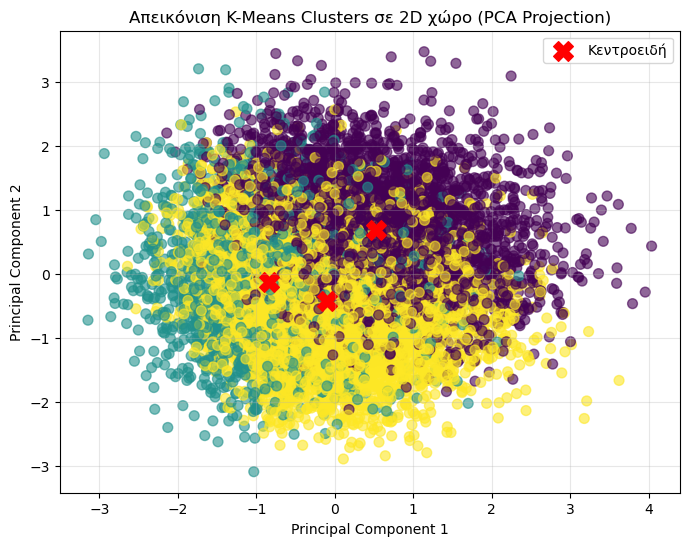

In [6]:
# ==== 8) Αξιολόγηση και Οπτικοποίηση Clustering ====
from sklearn.metrics import silhouette_score, davies_bouldin_score  #Εισαγωγή μετρικών ποιότητας για αντικειμενική αξιολόγηση συστάδων.
from sklearn.decomposition import PCA                               #Εισαγωγή της Ανάλυσης Κύριων Συνιστωσών (PCA) για δισδιάστατη απεικόνιση.

# Υπολογισμός μετρικών ποιότητας clustering
sil_score = silhouette_score(X_scaled, cluster_labels)     #Υπολογισμός του δείκτη Silhouette για τη συνοχή και τον διαχωρισμό των clusters.
db_score = davies_bouldin_score(X_scaled, cluster_labels)  #Υπολογισμός του δείκτη Davies–Bouldin, που αξιολογεί τη συμπαγή και διακριτή δομή των συστάδων.

print("\n=== Αξιολόγηση Clustering ===")
print() #Δημιουργία κενής γραμμής για οπτική ομοιομορφία.
print(f"1.Silhouette Score: {sil_score:.3f}  ->  Τιμές κοντά στο 1 υποδηλώνουν καλά διαχωρισμένες συστάδες.")
print(f"2.Davies–Bouldin Score: {db_score:.3f}  ->  Όσο μικρότερη η τιμή, τόσο καλύτερη η συνοχή και ο διαχωρισμός των clusters.")
print() #Δημιουργία κενής γραμμής για οπτική ομοιομορφία.

# ==== Οπτικοποίηση σε 2D με PCA ====
pca = PCA(n_components=2, random_state=42)   #Ορισμός PCA με δύο κύριες συνιστώσες για μείωση διαστάσεων σε επίπεδο 2D.
X_pca = pca.fit_transform(X_scaled)          #Εφαρμογή μετασχηματισμού PCA στα τυποποιημένα δεδομένα για απεικόνιση.

plt.figure(figsize=(8,6))  #Δημιουργία καμβά γραφήματος με καθορισμένες διαστάσεις.
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50)  # Σχεδίαση σημείων δεδομένων βάσει των ετικετών συστάδας.
plt.scatter(pca.transform(centers_scaled)[:,0], pca.transform(centers_scaled)[:,1],
c='red', marker='X', s=200, label='Κεντροειδή')  #Εμφάνιση των κεντροειδών με κόκκινο χρώμα για αναφορά.
plt.title("Απεικόνιση K-Means Clusters σε 2D χώρο (PCA Projection)") #Τίτλος γραφήματος με περιγραφική επισήμανση της μεθόδου.
plt.xlabel("Principal Component 1") #Ονομασία άξονα x.
plt.ylabel("Principal Component 2") #Ονομασία άξονα y.
plt.legend()   #Εμφάνιση υπόμνηματος για τα κεντροειδή.
plt.grid(alpha=0.3) #Ενεργοποίηση ελαφρού πλέγματος για αναγνωσιμότητα.
plt.show() #Απόδοση τελικού γραφήματος στην έξοδο.

### Αποτελέσματα Εφαρμογής K-Means (k=3)

Εφαρμόσαμε τον αλγόριθμο **K-Means** με *k=3* ώστε να ελέγξουμε αν τα κλινικά χαρακτηριστικά των ασθενών σχηματίζουν φυσικές ομάδες που να αντιστοιχούν στις κατηγορίες κινδύνου *(Low, Medium, High)*.  

- Τα αποτελέσματα έδειξαν ότι οι ομάδες που προκύπτουν **δεν ξεχωρίζουν καθαρά** τις κατηγορίες ρίσκου.  
- Οι μέσοι όροι των χαρακτηριστικών είναι πολύ κοντά μεταξύ τους.  
- Κάθε cluster περιέχει **μίξη κατηγοριών**, χωρίς σαφή διαχωρισμό.  

---

### Συμπέρασμα
Οι υπάρχουσες κατηγορίες κινδύνου **δεν αναδύονται αυτόματα** από τα δεδομένα.  
Αυτό δικαιολογεί τη χρήση **επιβλεπόμενων μεθόδων** όπως η *Logistic Regression* και το *Random Forest* για πιο ακριβή πρόβλεψη.
